In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import geopandas as gpd
import glob

import matplotlib
import matplotlib.pyplot as plt

import statistics

from convertbng.util import convert_lonlat

pd.set_option('display.max_columns', 300)

tfont = {'fontname':'Liberation Sans Narrow', 'horizontalalignment':'left'}
from matplotlib import rcParams
rcParams['font.family'] = 'Liberation Sans Narrow'

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
import matplotlib.style as style
# style.available

style.use('fivethirtyeight')
# style.use('ggplot')

### Get geocoord of bus counts

In [ ]:
bus_stops = pd.read_csv('../data/buses/bus-stops.csv')
bus_routes = pd.read_csv('../data/buses/bus-sequences.csv')

In [ ]:
print(bus_stops.shape)
bus_stops.head(3)

In [ ]:
# convert BNG Eastings and Northings to longitude, latitude
def bng_to_latlon(df):
    df['coord']= convert_lonlat([df['Location_Easting']], [df['Location_Northing']])
    return df

In [ ]:
bus_stops = bus_stops.apply(bng_to_latlon, axis=1)
bus_stops['lon'] = bus_stops.coord.apply(lambda x: x[0][0])
bus_stops['lat'] = bus_stops.coord.apply(lambda x: x[1][0])

gdf_stops = gpd.GeoDataFrame(bus_stops,
      geometry=gpd.points_from_xy(bus_stops['lon'], bus_stops['lat'], crs='epsg:4326'))

gdf_stops.to_crs('epsg:27700', inplace=True)
gdf_stops.drop(columns=['coord','lon','lat'], inplace=True)

gdf_stops.drop(columns=['Bus_Stop_Code', 'Naptan_Atco', 
       'Location_Easting', 'Location_Northing', 'Heading', 'Stop_Area',
       'Virtual_Bus_Stop'], inplace=True)

# gdf_stops.to_file("data/buses/bus_stops_locations.geojson", driver='GeoJSON')

In [ ]:
gdf_stops.to_file("data/buses/bus_stops_locations.geojson", driver='GeoJSON')

In [3]:
msoa_cropped = gpd.read_file('../data/output.msoa_cropped.geojson')

In [4]:
stops = gpd.read_file('../data/buses/bus_stops_locations.geojson')

In [5]:
print(stops.shape)
stops.head()

(20424, 3)


,Stop_Code_LBSL,Stop_Name,geometry
0,1000,WESTMINSTER STN <> / PARLIAMENT SQUARE,POINT (530172.734 179738.188)
1,10001,TREVOR CLOSE,POINT (515782.518 174782.990)
2,10002,HIGHBURY CORNER,POINT (531615.813 184603.294)
3,10003,HIGHBURY & ISLINGTON STATION <> #,POINT (531552.815 184803.298)
4,10004,ST MARY MAGDALENE CHURCH,POINT (531366.812 184986.306)


Data request:
The number of passengers boarding by hour at each bus stop (by Stop_Code_LBSL)  in London between 1/Jan/2018 and 31/May/2021

In [8]:
path201906 = '../data/buses/requested_taps/Taps 20190601 - 20190630 FOI Data/Taps 20190601 - 20190630 FOI Data.csv'
path202006 = '../data/buses/requested_taps/Taps 20200601 - 20200630 FOI Data/Taps 20200601 - 20200630 FOI Data.csv'
path202106 = '../data/buses/requested_taps/Taps 20210601 - 20210630 FOI Data/Taps 20210601 - 20210630 FOI Data.csv'

df201906 = pd.read_csv(path201906)
df202006 = pd.read_csv(path202006)
df202106 = pd.read_csv(path202106)

In [11]:
df201906 = df201906.rename({'FROMNODEID' : 'stop_code'}, axis=1)
df202006 = df202006.rename({'FROMNODEID' : 'stop_code'}, axis=1)
df202106 = df202106.rename({'FROMNODEID' : 'stop_code'}, axis=1)

In [12]:
df201906 = df201906[df201906['stop_code'].isin(list(stop_to_msoa_cropped['stop_code']))]
df202006 = df202006[df202006['stop_code'].isin(list(stop_to_msoa_cropped['stop_code']))]
df202106 = df202106[df202106['stop_code'].isin(list(stop_to_msoa_cropped['stop_code']))]

In [13]:
print(df201906.shape)
print(df202006.shape)
print(df202106.shape)

df202106.head(2)

(74975, 27)
(67519, 27)
(75435, 27)


,DATE,stop_code,0,04:00 - 04:30,04:30 - 05:00,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,3,5,6,7,8,9
0,2021-06-01,1000,9,< 5,< 5,12,16,16,21,22,24,56,45,63,58,35,6,23,37,8,15,5,5,12,28,32,17
30,2021-06-01,1017,< 5,< 5,< 5,< 5,21,20,18,29,23,29,30,44,30,24,< 5,21,31,21,8,< 5,0,< 5,9,22,15


In [15]:
df_list = [df201906, df202006, df202106]

In [9]:
print(df201906.shape)
print(df202006.shape)
print(df202106.shape)

df202106.head(2)

(563503, 27)
(455841, 27)
(556112, 27)


,DATE,FROMNODEID,0,04:00 - 04:30,04:30 - 05:00,1,10,11,12,13,14,15,16,17,18,19,2,20,21,22,23,3,5,6,7,8,9
0,2021-06-01,1000,9,< 5,< 5,12,16,16,21,22,24,56,45,63,58,35,6,23,37,8,15,5,5,12,28,32,17
1,2021-06-01,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,< 5,0,0,0,0,0,0,0,0,0,0,0


In [10]:
df202106.columns

Index(['DATE', 'stop_code', '0', '04:00 - 04:30', '04:30 - 05:00', '1', '10',
       '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21',
       '22', '23', '3', '5', '6', '7', '8', '9'],
      dtype='object')

In [16]:
for df in df_list:
    for column in df.columns:
        df[column] = df[column].str.replace('< 5', '5')
    for column in df.columns[2:]:
        df[column] = df[column].astype(int)
    df['4'] = df['04:00 - 04:30'] + df['04:30 - 05:00']
    df.drop(columns=['04:00 - 04:30', '04:30 - 05:00'], inplace=True)

In [17]:
# order columns, doesn't work in the for loop
df201906 = df201906[['DATE', 'stop_code', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', 
         '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']]
df202006 = df202006[['DATE', 'stop_code', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', 
         '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']]
df202106 = df202106[['DATE', 'stop_code', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', 
         '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23']]

In [13]:
df202106.head(2)

,DATE,stop_code,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,2021-06-01,1000,9,12,6,5,10,5,12,28,32,17,16,16,21,22,24,56,45,63,58,35,23,37,8,15
1,2021-06-01,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0


In [18]:
df_list = [df201906, df202006, df202106]
for df in df_list:
    df['d'] = pd.to_datetime(df['DATE'].values, infer_datetime_format=True)

In [15]:
df202106.head()

,DATE,stop_code,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,d
0,2021-06-01,1000,9,12,6,5,10,5,12,28,32,17,16,16,21,22,24,56,45,63,58,35,23,37,8,15,2021-06-01
1,2021-06-01,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2021-06-01
2,2021-06-01,10002,15,5,7,5,0,6,7,13,11,29,24,35,35,27,44,42,42,34,34,18,17,26,11,7,2021-06-01
3,2021-06-01,10003,8,5,5,5,5,5,24,51,36,32,21,29,41,38,39,61,59,56,71,46,41,26,15,6,2021-06-01
4,2021-06-01,10004,5,0,5,5,5,5,5,10,11,12,23,16,23,17,20,17,12,12,9,12,9,6,5,0,2021-06-01


In [19]:
df201906_d_totals = df201906.iloc[:,2:].groupby(['d']).agg(lambda x: x.sum()).reset_index()
df202006_d_totals = df202006.iloc[:,2:].groupby(['d']).agg(lambda x: x.sum()).reset_index()
df202106_d_totals = df202106.iloc[:,2:].groupby(['d']).agg(lambda x: x.sum()).reset_index()

In [20]:
d_totals_list = [df201906_d_totals, df202006_d_totals, df202106_d_totals]

In [21]:
for df in d_totals_list:
    # create dayofweek column with Monday=0 and Sunday=6
    df['dow'] = df.d.dt.dayofweek
    conditions = [df['dow']==0, df['dow']==1, df['dow']==2, df['dow']==3, df['dow']==4, df['dow']==5, df['dow']==6
             ]
    values = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['dayofweek'] = np.select(conditions, values)

In [19]:
df201906_d_totals.head(2)

,d,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,dow,dayofweek
0,2019-06-01,123219,57701,36011,29297,37925,70089,130586,171278,212422,287483,338678,382727,412535,427792,417977,401917,396190,392135,368085,318274,230145,171930,201598,179954,5,Saturday
1,2019-06-02,68764,29224,18767,21788,38258,46711,84170,115940,143204,199352,252453,292538,326128,339984,331015,323511,305383,287073,266602,222302,182742,139279,129661,103592,6,Sunday


## 1. Total traffic over all stops per day

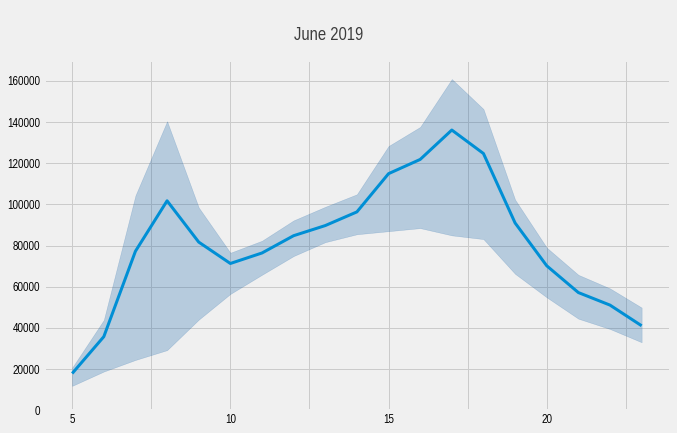

In [57]:
fig, ax = plt.subplots(figsize=(10,6))

x = df201906_d_totals.loc[:, '5':'23'].mean()

x.plot(ax=ax, linewidth=3)
q1 = df201906_d_totals.loc[:, '5':'23'].quantile(0.1)
q3 = df201906_d_totals.loc[:, '5':'23'].quantile(0.9)
ax.fill_between(x.index, q1, q3, color='#0C5DA5', alpha=0.25);

ax.tick_params(axis = 'both', which = 'major', labelsize = 12)

# ax.axhline(y = 0, color = 'black', linewidth = 0.8, alpha = .7)
# ax.axvline(x = 0, color = 'black', linewidth = 0.8, alpha = .7)

ax.set_ylim(bottom = 0, top = 170000);

ax.text(x = 7, y = 180000, s = "\nJune 2019",
               fontsize = 18, alpha = .75)

fig.savefig('../output/bus_total_hourly_201906')

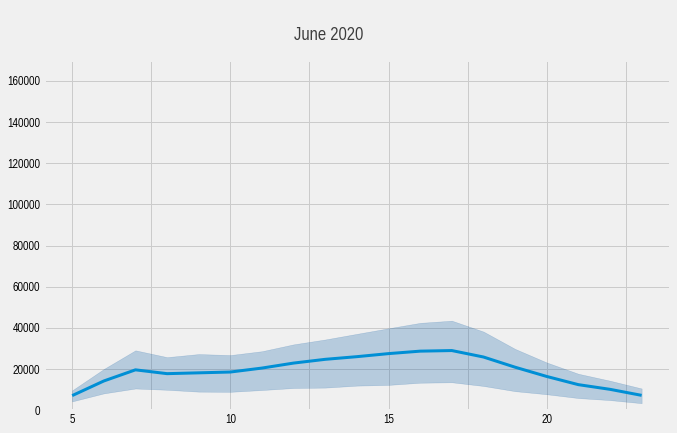

In [62]:
fig, ax = plt.subplots(figsize=(10,6))

x = df202006_d_totals.loc[:, '5':'23'].mean()

x.plot(ax=ax, linewidth=3)
q1 = df202006_d_totals.loc[:, '5':'23'].quantile(0.1)
q3 = df202006_d_totals.loc[:, '5':'23'].quantile(0.9)
ax.fill_between(x.index, q1, q3, color='#0C5DA5', alpha=0.25);

ax.tick_params(axis = 'both', which = 'major', labelsize = 12)

# ax.axhline(y = 0, color = 'black', linewidth = 1, alpha = .7)
# ax.axvline(x = 0, color = 'black', linewidth = 1, alpha = .7)

ax.set_ylim(bottom = 0, top = 170000);

ax.text(x = 7, y = 180000, s = "\nJune 2020",
               fontsize = 18, alpha = .75)

fig.savefig('../output/bus_total_hourly_202006')

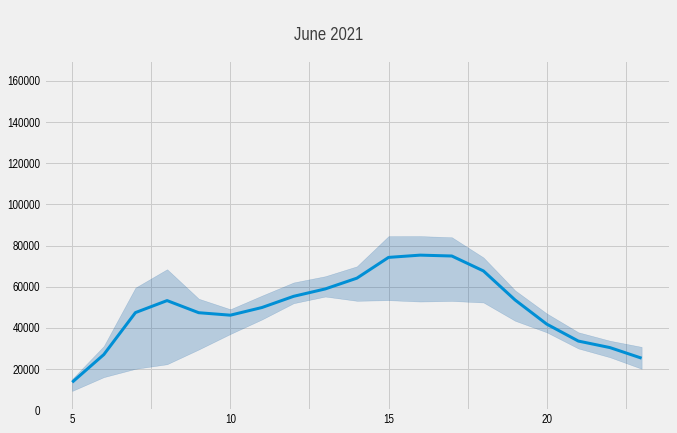

In [61]:
fig, ax = plt.subplots(figsize=(10,6))

x = df202106_d_totals.loc[:, '5':'23'].mean()

x.plot(ax=ax, linewidth=3)
q1 = df202106_d_totals.loc[:, '5':'23'].quantile(0.1)
q3 = df202106_d_totals.loc[:, '5':'23'].quantile(0.9)
ax.fill_between(x.index, q1, q3, color='#0C5DA5', alpha=0.25);

ax.tick_params(axis = 'both', which = 'major', labelsize = 12)

# ax.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
# ax.axvline(x = 0, color = 'black', linewidth = 5, alpha = .7)

ax.set_ylim(bottom = 0, top = 170000);

ax.text(x = 7, y = 180000, s = "\nJune 2021",
               fontsize = 18, alpha = .75)

fig.savefig('../output/bus_total_hourly_202106')

### By day of week

In [63]:
weekday201906 = df201906_d_totals.loc[(df201906_d_totals['dayofweek'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])), '5':'23']
friday201906 = df201906_d_totals.loc[(df201906_d_totals['dayofweek']=='Friday'), '5':'23']
saturday201906 = df201906_d_totals.loc[(df201906_d_totals['dayofweek']=='Saturday'), '5':'23']
sunday201906 = df201906_d_totals.loc[(df201906_d_totals['dayofweek']=='Sunday'), '5':'23']

a = weekday201906.mean()
b = friday201906.mean()
c = saturday201906.mean()
d = sunday201906.mean()

dow_hourly_201906 = pd.DataFrame(list(zip(a,b,c,d)), columns=['weekday', 'friday', 'saturday', 'sunday'],
                                index=range(5,24))

In [64]:
Col1 = '#fb9a99' #red
Col2 = '#e31a1c'

Col3 = '#4db8ff' #blue
Col4 = '#0000e6'

Col5 = '#33cc33' # green
Col6 = '#009933'

colors = [Col1, Col2, Col3, Col4, Col5, Col6]

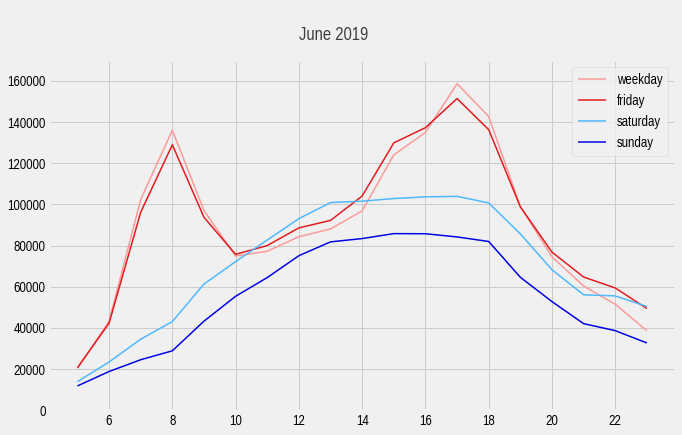

In [68]:
fig, ax = plt.subplots(figsize=(10,6))

h_plot = dow_hourly_201906.plot(ax=ax, linewidth=1.5, color = colors)
x_ticks = [6,8,10,12,14,16,18,20,22]
x_ticks_labels = [6,8,10,12,14,16,18,20,22]

ax.set_xticks(x_ticks) 
ax.set_xticklabels(x_ticks_labels)

h_plot.tick_params(axis = 'both', which = 'major', labelsize = 14)

# h_plot.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
# h_plot.axvline(x = 5, color = 'black', linewidth = 5, alpha = .7)

h_plot.set_ylim(bottom = 0, top = 170000)

ax.text(x = 12, y = 180000, s = "\nJune 2019",
               fontsize = 18, alpha = .75)

fig.savefig('../output/bus_dow_201906')

In [70]:
weekday202006 = df202006_d_totals.loc[(df202006_d_totals['dayofweek'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])), '5':'23']
friday202006 = df202006_d_totals.loc[(df202006_d_totals['dayofweek']=='Friday'), '5':'23']
saturday202006 = df202006_d_totals.loc[(df202006_d_totals['dayofweek']=='Saturday'), '5':'23']
sunday202006 = df202006_d_totals.loc[(df202006_d_totals['dayofweek']=='Sunday'), '5':'23']

a = weekday202006.mean()
b = friday202006.mean()
c = saturday202006.mean()
d = sunday202006.mean()

dow_hourly_202006 = pd.DataFrame(list(zip(a,b,c,d)), columns=['weekday', 'friday', 'saturday', 'sunday'],
                                index=range(5,24))

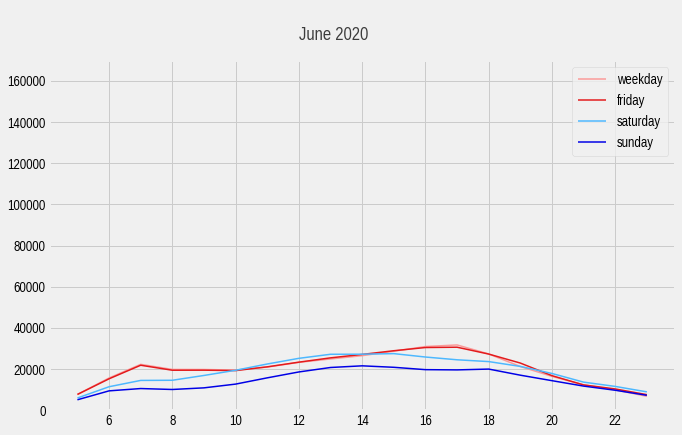

In [71]:
fig, ax = plt.subplots(figsize=(10,6))

h_plot = dow_hourly_202006.plot(ax=ax, linewidth=1.5, color = colors)
x_ticks = [6,8,10,12,14,16,18,20,22]
x_ticks_labels = [6,8,10,12,14,16,18,20,22]

ax.set_xticks(x_ticks) 
ax.set_xticklabels(x_ticks_labels)

h_plot.tick_params(axis = 'both', which = 'major', labelsize = 14)

# h_plot.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
# h_plot.axvline(x = 5, color = 'black', linewidth = 5, alpha = .7)

h_plot.set_ylim(bottom = 0, top = 170000)

ax.text(x = 12, y = 180000, s = "\nJune 2020",
               fontsize = 18, alpha = .75)

fig.savefig('../output/bus_dow_202006a')

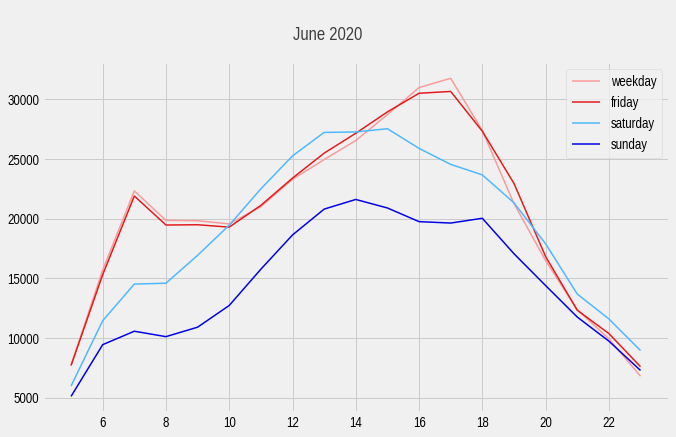

In [77]:
fig, ax = plt.subplots(figsize=(10,6))

h_plot = dow_hourly_202006.plot(ax=ax, linewidth=1.5, color = colors)
x_ticks = [6,8,10,12,14,16,18,20,22]
x_ticks_labels = [6,8,10,12,14,16,18,20,22]

ax.set_xticks(x_ticks) 
ax.set_xticklabels(x_ticks_labels)

h_plot.tick_params(axis = 'both', which = 'major', labelsize = 14)

# h_plot.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
# h_plot.axvline(x = 5, color = 'black', linewidth = 5, alpha = .7)

ax.text(x = 12, y = 35000, s = "\nJune 2020",
               fontsize = 18, alpha = .75)

fig.savefig('../output/bus_dow_202006b')

In [78]:
weekday202106 = df202106_d_totals.loc[(df202106_d_totals['dayofweek'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])), '5':'23']
friday202106 = df202106_d_totals.loc[(df202106_d_totals['dayofweek']=='Friday'), '5':'23']
saturday202106 = df202106_d_totals.loc[(df202106_d_totals['dayofweek']=='Saturday'), '5':'23']
sunday202106 = df202106_d_totals.loc[(df202106_d_totals['dayofweek']=='Sunday'), '5':'23']

a = weekday202106.mean()
b = friday202106.mean()
c = saturday202106.mean()
d = sunday202106.mean()

dow_hourly_202106 = pd.DataFrame(list(zip(a,b,c,d)), columns=['weekday', 'friday', 'saturday', 'sunday'],
                                index=range(5,24))

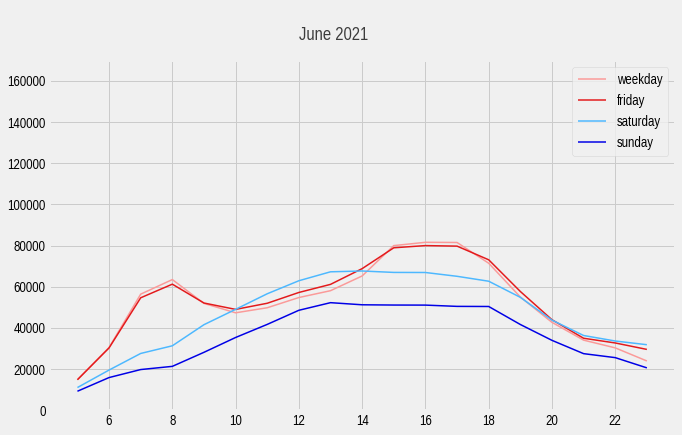

In [79]:
fig, ax = plt.subplots(figsize=(10,6))

h_plot = dow_hourly_202106.plot(ax=ax, linewidth=1.5, color = colors)
x_ticks = [6,8,10,12,14,16,18,20,22]
x_ticks_labels = [6,8,10,12,14,16,18,20,22]

ax.set_xticks(x_ticks) 
ax.set_xticklabels(x_ticks_labels)

h_plot.tick_params(axis = 'both', which = 'major', labelsize = 14)

# h_plot.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
# h_plot.axvline(x = 5, color = 'black', linewidth = 5, alpha = .7)

h_plot.set_ylim(bottom = 0, top = 170000)

ax.text(x = 12, y = 180000, s = "\nJune 2021",
               fontsize = 18, alpha = .75);

fig.savefig('../output/bus_dow_202106')

### Crop to the study area

In [31]:
stops_gdf = gpd.read_file('../data/buses/bus_stops_locations.geojson')
stops_gdf = stops_gdf.rename({'Stop_Code_LBSL' : 'stop_code'}, axis=1)

In [32]:
London = gpd.read_file('../data/london_general/London_boundaries.geojson')

lsoa = gpd.read_file('../data/london_general/statistical-gis-boundaries-london/ESRI/LSOA_2011_London_gen_MHW.shp')
lsoa = lsoa.to_crs('epsg:27700')

msoa = gpd.read_file('../data/london_general/statistical-gis-boundaries-london/ESRI/MSOA_2011_London_gen_MHW.shp')
msoa = msoa.to_crs('epsg:27700')

In [33]:
msoa_cropped = gpd.read_file('../data/output.msoa_cropped.geojson')

In [34]:
#join stops with msoa-s
stop_to_msoa_gdf = gpd.sjoin(stops_gdf, msoa, how="inner", op="within")
stop_to_msoa = stop_to_msoa_gdf[['MSOA11CD', 'MSOA11NM', 'stop_code', 'Stop_Name']]

stop_to_msoa_cropped_gdf = gpd.sjoin(stops_gdf, msoa_cropped, how="inner", op="within")
stop_to_msoa_cropped = stop_to_msoa_cropped_gdf[['MSOA11CD', 'MSOA11NM', 'stop_code', 'Stop_Name']]

In [35]:
# stop_to_msoa.to_csv('../data/buses/stop_to_msoa.csv', index=False)
# stop_to_msoa_cropped.to_csv('../data/buses/stop_to_msoa_cropped.csv', index=False)

In [7]:
stop_to_msoa_cropped = pd.read_csv('../data/buses/stop_to_msoa_cropped.csv')

In [36]:
# list(stop_to_msoa_cropped['stop_code'])

In [37]:
df201906
df202006
df202106

,DATE,stop_code,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,d
0,2021-06-01,1000,9,12,6,5,10,5,12,28,32,17,16,16,21,22,24,56,45,63,58,35,23,37,8,15,2021-06-01
1,2021-06-01,10001,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,2021-06-01
2,2021-06-01,10002,15,5,7,5,0,6,7,13,11,29,24,35,35,27,44,42,42,34,34,18,17,26,11,7,2021-06-01
3,2021-06-01,10003,8,5,5,5,5,5,24,51,36,32,21,29,41,38,39,61,59,56,71,46,41,26,15,6,2021-06-01
4,2021-06-01,10004,5,0,5,5,5,5,5,10,11,12,23,16,23,17,20,17,12,12,9,12,9,6,5,0,2021-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556107,2021-06-30,W46,5,0,5,5,5,48,129,172,151,96,97,69,67,55,109,62,80,82,79,43,38,22,9,13,2021-06-30
556108,2021-06-30,W48,49,16,12,6,26,38,59,154,146,119,86,104,143,130,146,174,224,265,281,157,138,104,82,76,2021-06-30
556109,2021-06-30,W5,0,0,0,0,5,5,6,5,5,5,5,0,0,0,7,5,0,5,0,5,0,0,0,0,2021-06-30
556110,2021-06-30,W6,0,0,0,0,0,0,0,5,12,5,5,7,5,0,5,5,5,5,5,0,0,0,0,0,2021-06-30


In [38]:
df202106.shape

(556112, 27)

In [39]:
df201906_c = df201906[df201906['stop_code'].isin(list(stop_to_msoa_cropped['stop_code']))]
df202006_c = df202006[df202006['stop_code'].isin(list(stop_to_msoa_cropped['stop_code']))]
df202106_c = df202106[df202106['stop_code'].isin(list(stop_to_msoa_cropped['stop_code']))]

In [40]:
df201906_d_totals_c = df201906_c.iloc[:,2:].groupby(['d']).agg(lambda x: x.sum()).reset_index()
df202006_d_totals_c = df202006_c.iloc[:,2:].groupby(['d']).agg(lambda x: x.sum()).reset_index()
df202106_d_totals_c = df202106_c.iloc[:,2:].groupby(['d']).agg(lambda x: x.sum()).reset_index()

In [41]:
d_totals_list_c = [df201906_d_totals_c, df202006_d_totals_c, df202106_d_totals_c]

In [42]:
for df in d_totals_list_c:
    # create dayofweek column with Monday=0 and Sunday=6
    df['dow'] = df.d.dt.dayofweek
    conditions = [df['dow']==0, df['dow']==1, df['dow']==2, df['dow']==3, df['dow']==4, df['dow']==5, df['dow']==6
             ]
    values = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['dayofweek'] = np.select(conditions, values)

In [43]:
x.max()

347421.26666666666

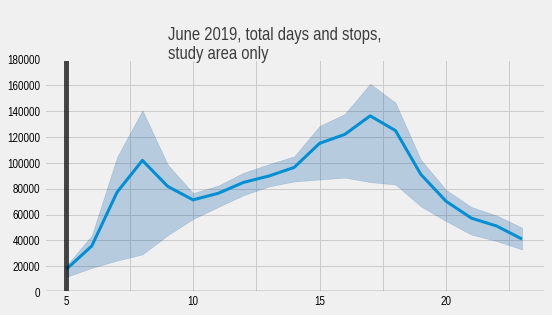

In [44]:
fig, ax = plt.subplots(figsize=(8,4))

x = df201906_d_totals_c.loc[:, '5':'23'].mean()

x.plot(ax=ax, linewidth=3)
q1 = df201906_d_totals_c.loc[:, '5':'23'].quantile(0.1)
q3 = df201906_d_totals_c.loc[:, '5':'23'].quantile(0.9)
ax.fill_between(x.index, q1, q3, color='#0C5DA5', alpha=0.25);

ax.tick_params(axis = 'both', which = 'major', labelsize = 12)

ax.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
ax.axvline(x = 0, color = 'black', linewidth = 5, alpha = .7)

ax.set_ylim(bottom = 0, top = 180000);

ax.text(x = 4, y = 180000, s = "\nJune 2019, total days and stops, \nstudy area only",
               fontsize = 18, alpha = .75);

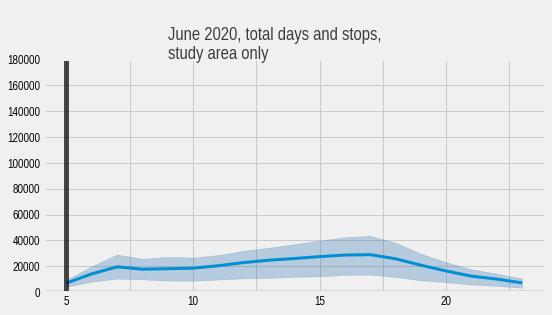

In [45]:
fig, ax = plt.subplots(figsize=(8,4))

x = df202006_d_totals_c.loc[:, '5':'23'].mean()

x.plot(ax=ax, linewidth=3)
q1 = df202006_d_totals_c.loc[:, '5':'23'].quantile(0.1)
q3 = df202006_d_totals_c.loc[:, '5':'23'].quantile(0.9)
ax.fill_between(x.index, q1, q3, color='#0C5DA5', alpha=0.25);

ax.tick_params(axis = 'both', which = 'major', labelsize = 12)

ax.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
ax.axvline(x = 0, color = 'black', linewidth = 5, alpha = .7)

ax.set_ylim(bottom = 0, top = 180000);

ax.text(x = 4, y = 180000, s = "\nJune 2020, total days and stops, \nstudy area only",
               fontsize = 18, alpha = .75);

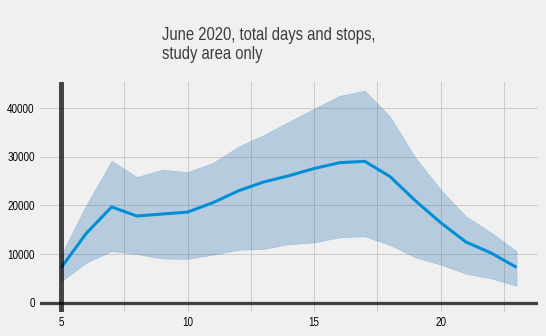

In [46]:
fig, ax = plt.subplots(figsize=(8,4))

x = df202006_d_totals_c.loc[:, '5':'23'].mean()

x.plot(ax=ax, linewidth=3)
q1 = df202006_d_totals_c.loc[:, '5':'23'].quantile(0.1)
q3 = df202006_d_totals_c.loc[:, '5':'23'].quantile(0.9)
ax.fill_between(x.index, q1, q3, color='#0C5DA5', alpha=0.25);

ax.tick_params(axis = 'both', which = 'major', labelsize = 12)

ax.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
ax.axvline(x = 0, color = 'black', linewidth = 5, alpha = .7)

# ax.set_ylim(bottom = 0, top = 180000);

ax.text(x = 4, y = 50000, s = "\nJune 2020, total days and stops, \nstudy area only",
               fontsize = 18, alpha = .75);

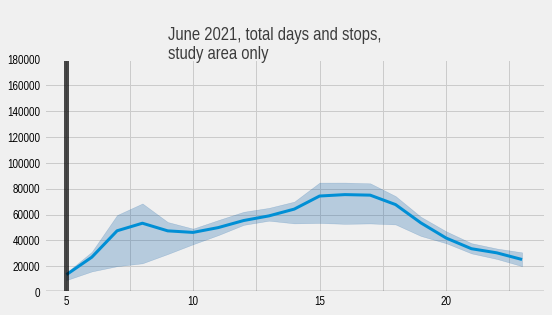

In [47]:
fig, ax = plt.subplots(figsize=(8,4))

x = df202106_d_totals_c.loc[:, '5':'23'].mean()

x.plot(ax=ax, linewidth=3)
q1 = df202106_d_totals_c.loc[:, '5':'23'].quantile(0.1)
q3 = df202106_d_totals_c.loc[:, '5':'23'].quantile(0.9)
ax.fill_between(x.index, q1, q3, color='#0C5DA5', alpha=0.25);

ax.tick_params(axis = 'both', which = 'major', labelsize = 12)

ax.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
ax.axvline(x = 0, color = 'black', linewidth = 5, alpha = .7)

ax.set_ylim(bottom = 0, top = 180000);

ax.text(x = 4, y = 180000, s = "\nJune 2021, total days and stops, \nstudy area only",
               fontsize = 18, alpha = .75);

In [48]:
weekday201906_c = df201906_d_totals_c.loc[(df201906_d_totals_c['dayofweek'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])), '5':'23']
friday201906_c = df201906_d_totals_c.loc[(df201906_d_totals_c['dayofweek']=='Friday'), '5':'23']
saturday201906_c = df201906_d_totals_c.loc[(df201906_d_totals_c['dayofweek']=='Saturday'), '5':'23']
sunday201906_c = df201906_d_totals_c.loc[(df201906_d_totals_c['dayofweek']=='Sunday'), '5':'23']

a = weekday201906_c.mean()
b = friday201906_c.mean()
c = saturday201906_c.mean()
d = sunday201906_c.mean()

dow_hourly_201906_c = pd.DataFrame(list(zip(a,b,c,d)), columns=['weekday', 'friday', 'saturday', 'sunday'],
                                index=range(5,24))

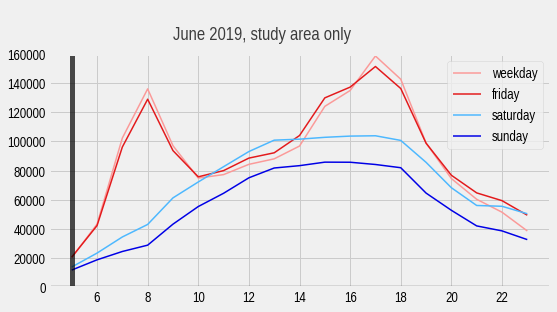

In [49]:
fig, ax = plt.subplots(figsize=(8,4))

h_plot = dow_hourly_201906_c.plot(ax=ax, linewidth=1.5, color = colors)
x_ticks = [6,8,10,12,14,16,18,20,22]
x_ticks_labels = [6,8,10,12,14,16,18,20,22]

ax.set_xticks(x_ticks) 
ax.set_xticklabels(x_ticks_labels)

h_plot.tick_params(axis = 'both', which = 'major', labelsize = 14)

h_plot.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
h_plot.axvline(x = 5, color = 'black', linewidth = 5, alpha = .7)

h_plot.set_ylim(bottom = 0, top = 160000);

h_plot.text(x = 9, y = 170000, s = "\nJune 2019, study area only",
               fontsize = 18, alpha = .75);

In [50]:
weekday202006_c = df202006_d_totals_c.loc[(df202006_d_totals_c['dayofweek'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])), '5':'23']
friday202006_c = df202006_d_totals_c.loc[(df202006_d_totals_c['dayofweek']=='Friday'), '5':'23']
saturday202006_c = df202006_d_totals_c.loc[(df202006_d_totals_c['dayofweek']=='Saturday'), '5':'23']
sunday202006_c = df202006_d_totals_c.loc[(df202006_d_totals_c['dayofweek']=='Sunday'), '5':'23']

a = weekday202006_c.mean()
b = friday202006_c.mean()
c = saturday202006_c.mean()
d = sunday202006_c.mean()

dow_hourly_202006_c = pd.DataFrame(list(zip(a,b,c,d)), columns=['weekday', 'friday', 'saturday', 'sunday'],
                                index=range(5,24))

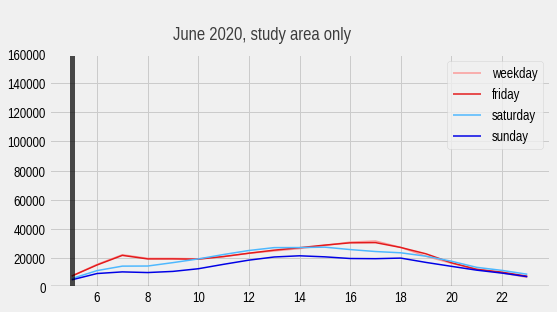

In [51]:
fig, ax = plt.subplots(figsize=(8,4))

h_plot = dow_hourly_202006_c.plot(ax=ax, linewidth=1.5, color = colors)
x_ticks = [6,8,10,12,14,16,18,20,22]
x_ticks_labels = [6,8,10,12,14,16,18,20,22]

ax.set_xticks(x_ticks) 
ax.set_xticklabels(x_ticks_labels)

h_plot.tick_params(axis = 'both', which = 'major', labelsize = 14)

h_plot.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
h_plot.axvline(x = 5, color = 'black', linewidth = 5, alpha = .7)

h_plot.set_ylim(bottom = 0, top = 160000);

h_plot.text(x = 9, y = 170000, s = "\nJune 2020, study area only",
               fontsize = 18, alpha = .75);

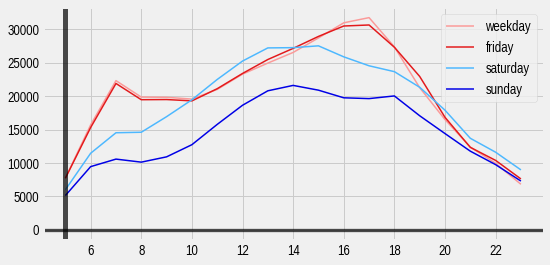

In [52]:
fig, ax = plt.subplots(figsize=(8,4))

h_plot = dow_hourly_202006_c.plot(ax=ax, linewidth=1.5, color = colors)
x_ticks = [6,8,10,12,14,16,18,20,22]
x_ticks_labels = [6,8,10,12,14,16,18,20,22]

ax.set_xticks(x_ticks) 
ax.set_xticklabels(x_ticks_labels)

h_plot.tick_params(axis = 'both', which = 'major', labelsize = 14)

h_plot.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
h_plot.axvline(x = 5, color = 'black', linewidth = 5, alpha = .7)

# h_plot.set_ylim(bottom = 0, top = 160000);

# h_plot.text(x = 12, y = 170000, s = "\nJune 2020, study area only",
#                fontsize = 18, alpha = .75);

In [53]:
weekday202106_c = df202106_d_totals_c.loc[(df202106_d_totals_c['dayofweek'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday'])), '5':'23']
friday202106_c = df202106_d_totals_c.loc[(df202106_d_totals_c['dayofweek']=='Friday'), '5':'23']
saturday202106_c = df202106_d_totals_c.loc[(df202106_d_totals_c['dayofweek']=='Saturday'), '5':'23']
sunday202106_c = df202106_d_totals_c.loc[(df202106_d_totals_c['dayofweek']=='Sunday'), '5':'23']

a = weekday202106_c.mean()
b = friday202106_c.mean()
c = saturday202106_c.mean()
d = sunday202106_c.mean()

dow_hourly_202106_c = pd.DataFrame(list(zip(a,b,c,d)), columns=['weekday', 'friday', 'saturday', 'sunday'],
                                index=range(5,24))

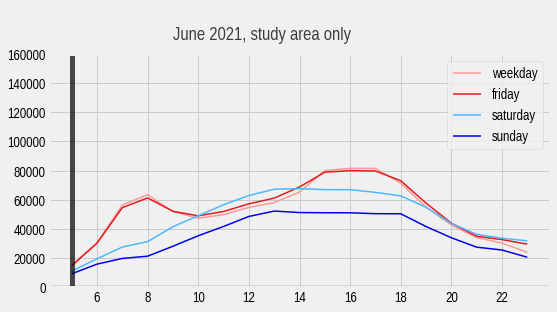

In [54]:
fig, ax = plt.subplots(figsize=(8,4))

h_plot = dow_hourly_202106_c.plot(ax=ax, linewidth=1.5, color = colors)
x_ticks = [6,8,10,12,14,16,18,20,22]
x_ticks_labels = [6,8,10,12,14,16,18,20,22]

ax.set_xticks(x_ticks) 
ax.set_xticklabels(x_ticks_labels)

h_plot.tick_params(axis = 'both', which = 'major', labelsize = 14)

h_plot.axhline(y = 0, color = 'black', linewidth = 3.3, alpha = .7)
h_plot.axvline(x = 5, color = 'black', linewidth = 5, alpha = .7)

h_plot.set_ylim(bottom = 0, top = 160000);

h_plot.text(x = 9, y = 170000, s = "\nJune 2021, study area only",
               fontsize = 18, alpha = .75);

### Aggregate to MSOAs

In [55]:
buses_201906_c = df201906_c.merge(stop_to_msoa_cropped, how='left')
buses_202006_c = df202006_c.merge(stop_to_msoa_cropped, how='left')
buses_202106_c = df202106_c.merge(stop_to_msoa_cropped, how='left')

In [56]:
b_list = [buses_201906_c, buses_202006_c, buses_202106_c]

for df in b_list:
    df['dow'] = df.d.dt.dayofweek
    conditions = [df['dow']==0, df['dow']==1, df['dow']==2, df['dow']==3, df['dow']==4, df['dow']==5, df['dow']==6]
    values = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    df['dayofweek'] = np.select(conditions, values)
    df.drop(columns='d', inplace=True)

In [57]:
buses_201906_c_weekend = buses_201906_c[buses_201906_c['dayofweek'].isin(['Saturday', 'Sunday'])]
buses_202006_c_weekend = buses_202006_c[buses_202006_c['dayofweek'].isin(['Saturday', 'Sunday'])]
buses_202106_c_weekend = buses_202106_c[buses_202106_c['dayofweek'].isin(['Saturday', 'Sunday'])]

In [58]:
b_list_weekend = [buses_201906_c_weekend, buses_202006_c_weekend, buses_202106_c_weekend]

for df in b_list_weekend:
    df['daily_sum'] = df[list(df.iloc[:,2:-6].columns)].sum(axis=1)
    df.drop(columns=list(df.iloc[:,2:-6]), inplace=True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4169: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [59]:
buses_201906_c_weekend.head()

,DATE,stop_code,MSOA11CD,MSOA11NM,Stop_Name,dow,dayofweek,daily_sum
0,2019-06-01,1000,E02000979,Westminster 020,WESTMINSTER STN <> / PARLIAMENT SQUARE,5,Saturday,202
1,2019-06-01,1017,E02000574,Islington 021,ST JOHN STREET / GOSWELL ROAD,5,Saturday,611
2,2019-06-01,10243,E02000386,Hammersmith and Fulham 015,MULGRAVE ROAD,5,Saturday,462
3,2019-06-01,10244,E02000385,Hammersmith and Fulham 014,FULHAM POOLS,5,Saturday,320
4,2019-06-01,1026,E02000960,Westminster 001,QUEEN'S GROVE,5,Saturday,236


In [60]:
b_msoa201906_sum = buses_201906_c_weekend[['MSOA11CD','DATE','daily_sum']].groupby(['MSOA11CD','DATE']).agg({'daily_sum':'sum'}).reset_index()
b_msoa202006_sum = buses_202006_c_weekend[['MSOA11CD','DATE','daily_sum']].groupby(['MSOA11CD','DATE']).agg({'daily_sum':'sum'}).reset_index()
b_msoa202106_sum = buses_202106_c_weekend[['MSOA11CD','DATE','daily_sum']].groupby(['MSOA11CD','DATE']).agg({'daily_sum':'sum'}).reset_index()

In [61]:
b_msoa201906 = b_msoa201906_sum.groupby(['MSOA11CD']).agg({'daily_sum':'mean'}).reset_index()
b_msoa202006 = b_msoa202006_sum.groupby(['MSOA11CD']).agg({'daily_sum':'mean'}).reset_index()
b_msoa202106 = b_msoa202106_sum.groupby(['MSOA11CD']).agg({'daily_sum':'mean'}).reset_index()

In [62]:
b_msoa201906.columns = ['MSOA11CD', 'b_passengers201906']
b_msoa202006.columns = ['MSOA11CD', 'b_passengers202006']
b_msoa202106.columns = ['MSOA11CD', 'b_passengers202106']

### Final dataset

In [5]:
# bus_msoa = b_msoa201906.merge(b_msoa202006).merge(b_msoa202106)
# bus_msoa.to_csv('../data/y/bus_msoa.csv', index = False)
bus_msoa = pd.read_csv('../data/y/bus_msoa.csv')

In [64]:
bus_msoa.head()

,MSOA11CD,b_passengers201906,b_passengers202006,b_passengers202106
0,E02000001,43690.9,11964.875,33398.250
1,E02000180,3913.1,1347.625,2538.125
2,E02000183,3271.1,922.750,1694.750
3,E02000184,12602.1,3319.625,7771.375
4,E02000186,18894.7,5888.125,11838.250


#### Spatial distributions

In [5]:
bus_msoa_gdf = msoa_cropped.merge(bus_msoa, how='left')

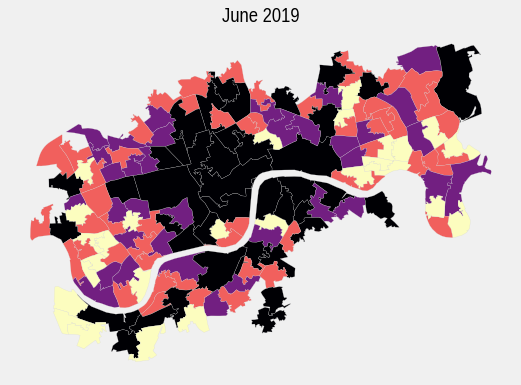

In [75]:
fig, ax1 = plt.subplots(figsize=(10,6))

bus_msoa_gdf.plot(ax=ax1, column='b_passengers201906', legend=False, cmap = 'magma_r',
                      edgecolor='lightgrey', linewidth = 0.2,
                  scheme="User_Defined", classification_kwds=dict(bins=[2500,5000,10000])
                 )

ax1.axis('off')
ax1.set_title("June 2019");
fig.savefig('../output/bus_t_map_201906');

In [31]:
style.use('default')

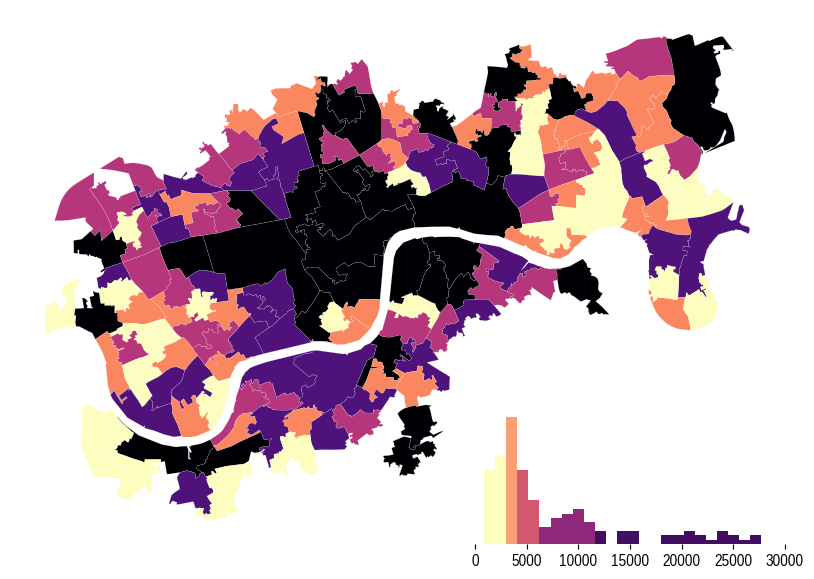

In [53]:
import pysal as ps
import mapclassify as mc
# https://jiffyclub.github.io/palettable/
import palettable.matplotlib as palmpl
from legendgram import legendgram

f,ax = plt.subplots(figsize=(10,8))
bus_msoa_gdf.plot(column='b_passengers201906', 
                  scheme='Quantiles', cmap='magma_r', k=5, 
                  linewidth=0.1, edgecolor='white',
                  ax=ax)
q = mc.Quantiles(bus_msoa_gdf.b_passengers201906.values, k=5)

# https://github.com/pysal/legendgram/blob/master/legendgram/legendgram.py
legendgram(plt.gcf(), ax, 
               bus_msoa_gdf.b_passengers201906, 
               q.bins, 
           pal=palmpl.Magma_5_r,
               legend_size=(.4,.25), # legend size in fractions of the axis
               loc = 'lower right', # mpl-style legend loc
               clip = (0,30000), # clip range of the histogram
#                frameon=True
          )

ax.axis('off');


<AxesSubplot:>

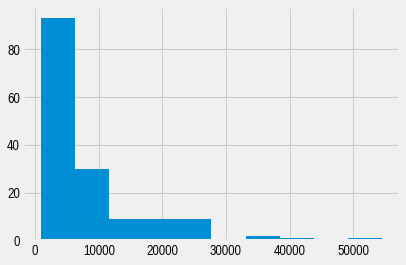

In [25]:
bus_msoa_gdf.b_passengers201906.hist()

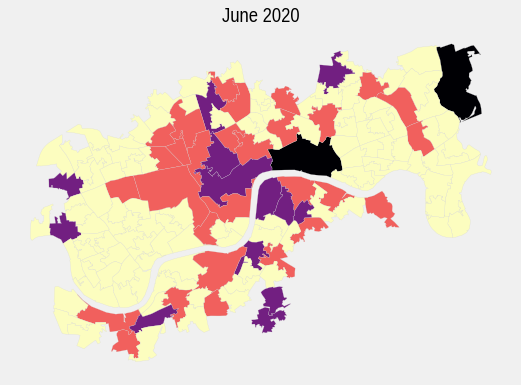

In [74]:
fig, ax2 = plt.subplots(figsize=(10,6))

bus_msoa_gdf.plot(ax=ax2, column='b_passengers202006', legend=False, cmap = 'magma_r',
                      edgecolor='lightgrey', linewidth = 0.2,
                  scheme="User_Defined", classification_kwds=dict(bins=[2500,5000,10000])
                 )

ax2.axis('off')
ax2.set_title("June 2020");
fig.savefig('../output/bus_t_map_202006');

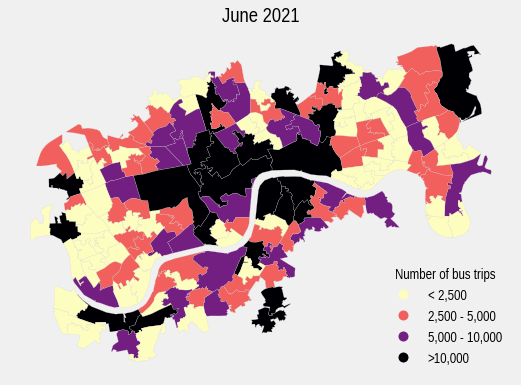

In [73]:
fig, ax3 = plt.subplots(figsize=(10,6))


legend_labels = ['< 2,500', '2,500 - 5,000', '5,000 - 10,000', '>10,000']

bus_msoa_gdf.plot(ax=ax3, column='b_passengers202106', 
                  legend=True, 
                  cmap = 'magma_r',
                  edgecolor='lightgrey', linewidth = 0.2,
                  scheme="User_Defined", classification_kwds=dict(bins=[2500,5000,10000]),
                  legend_kwds=dict(labels=legend_labels, loc='lower right', 
#                                    bbox_to_anchor=(1.5, 1), 
                                   prop=dict(family='Liberation Sans Narrow'),
                                   title="Number of bus trips", frameon=False))
ax3.axis('off')
ax3.set_title("June 2021");
fig.savefig('../output/bus_t_map_202106');

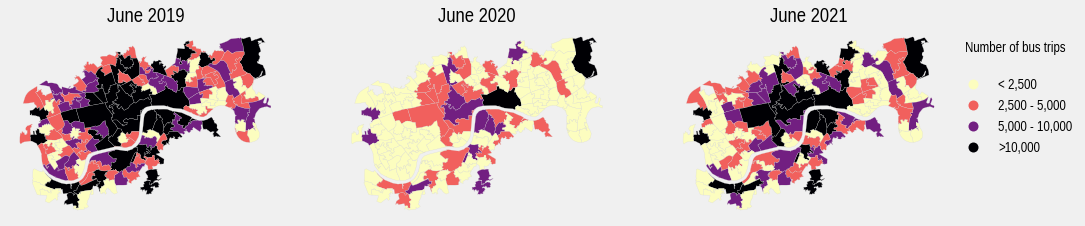

In [69]:
fig, axes = plt.subplots(1,3, figsize=(15,6))

legend_labels = ['< 2,500', '2,500 - 5,000', '5,000 - 10,000', '>10,000']

bus_msoa_gdf.plot(ax=axes[0], column='b_passengers201906', legend=False, cmap = 'magma_r',
                      edgecolor='lightgrey', linewidth = 0.2,
                  scheme="User_Defined", classification_kwds=dict(bins=[2500,5000,10000], k = 6)
                 )

bus_msoa_gdf.plot(ax=axes[1], column='b_passengers202006', legend=False, cmap = 'magma_r',
                  edgecolor='lightgrey', linewidth = 0.2,
                  scheme="User_Defined", classification_kwds=dict(bins=[2500,5000,10000])
                 )

bus_msoa_gdf.plot(ax=axes[2], column='b_passengers202106', 
                  legend=True, 
                  cmap = 'magma_r',
                  edgecolor='lightgrey', linewidth = 0.2,
                  scheme="User_Defined", classification_kwds=dict(bins=[2500,5000,10000]),
                  legend_kwds=dict(labels=legend_labels, loc='upper right', bbox_to_anchor=(1.5, 1), 
                                   prop=dict(family='Liberation Sans Narrow'),
                                   title="Number of bus trips\n", frameon=False)
                 )

for ax in axes:
        ax.title.set_font('Liberation Sans Narrow')
        ax.axis('off')
        
axes[0].set_title("June 2019");
axes[1].set_title("June 2020");
axes[2].set_title("June 2021");

# fig.savefig('../export/bus_maps0');

#### Descriptive stats

In [70]:
columns = ['b_passengers201906',
       'b_passengers202006', 'b_passengers202106']

df = bus_msoa[columns]

var_min = []
var_max = []
var_mean = []
var_stdev = []

for col in df:
    var_min.append(round(df[col].min(), 2))
    var_max.append(round(df[col].max(), 2))
    var_mean.append(round(df[col].mean(), 2))
    var_stdev.append(round(statistics.stdev(df[col]),2))

In [71]:
pd.DataFrame(list(zip(columns, var_min, var_max, var_mean, var_stdev)), columns=(['var','min','max','mean','stdev']))

,var,min,max,mean,stdev
0,b_passengers201906,868.50,54545.80,8361.43,8742.17
1,b_passengers202006,296.75,13189.75,2177.81,2111.72
2,b_passengers202106,506.00,33398.25,5468.88,5919.80


FileNotFoundError: [Errno 2] No such file or directory: '../export/bus_hist.png'

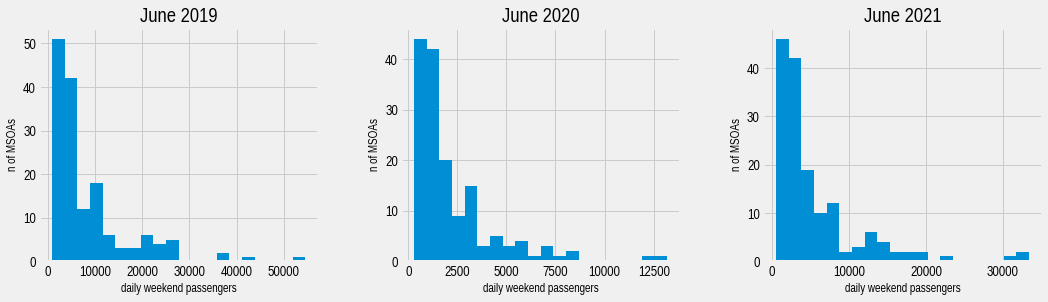

In [72]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

i = 0
df = bus_msoa.iloc[:,1:]

for ax in axes:
    df.hist(column = df.columns[i], bins = 20, ax=ax)
    ax.title.set_font('Liberation Sans Narrow')
    i = i+1
    ax.set_xlabel('daily weekend passengers', fontsize=12)
    ax.set_ylabel('n of MSOAs', fontsize=12)

axes[0].set_title("June 2019");
axes[1].set_title("June 2020");
axes[2].set_title("June 2021");


fig.savefig('../output/bus_hist')

In [ ]:
bus_msoa['b_counts201906_ln'] = np.log(bus_msoa['b_passengers201906'])
bus_msoa['b_counts202006_ln'] = np.log(bus_msoa['b_passengers202006'])
bus_msoa['b_counts202106_ln'] = np.log(bus_msoa['b_passengers202106'])

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(16,4))

i = 0
df = bus_msoa.iloc[:,4:]

for ax in axes:
    df.hist(column = df.columns[i], bins = 20, ax=ax)
    ax.title.set_font('Liberation Sans Narrow')
    i = i+1
    ax.set_xlabel('daily weekend passengers, ln', fontsize=12)
    ax.set_ylabel('n of MSOAs', fontsize=12)

axes[0].set_title("June 2019");
axes[1].set_title("June 2020");
axes[2].set_title("June 2021");

fig.savefig('../export/bus_hist_ln')